In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.ref_book import ReferenceBookAnonymization

In [3]:
set_seed(42)

In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Anonymization config initialisation
anon_config = yaml.load(open("configs/ref_book_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученная на датасете i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на датасете i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на датасете i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на датасете i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученная на датасете i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на датасете i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на датасете i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на датасете i2b2 2014 без учёта регистра
    5. Version 4 --- обученная на обезличенном датасете i2b2 2014 без учёта регистра

### Этап 1: Сравнение результатов на наборе данных i2b2 2014
Сравнение будет включает в себя измерение метрик Recall, Precision и $F_1$ score для следующий моделей:
* BERT-base-cased
* BERT-base-uncased
* BERT-large-cased
* BERT-large-uncased

#### BERT-base-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

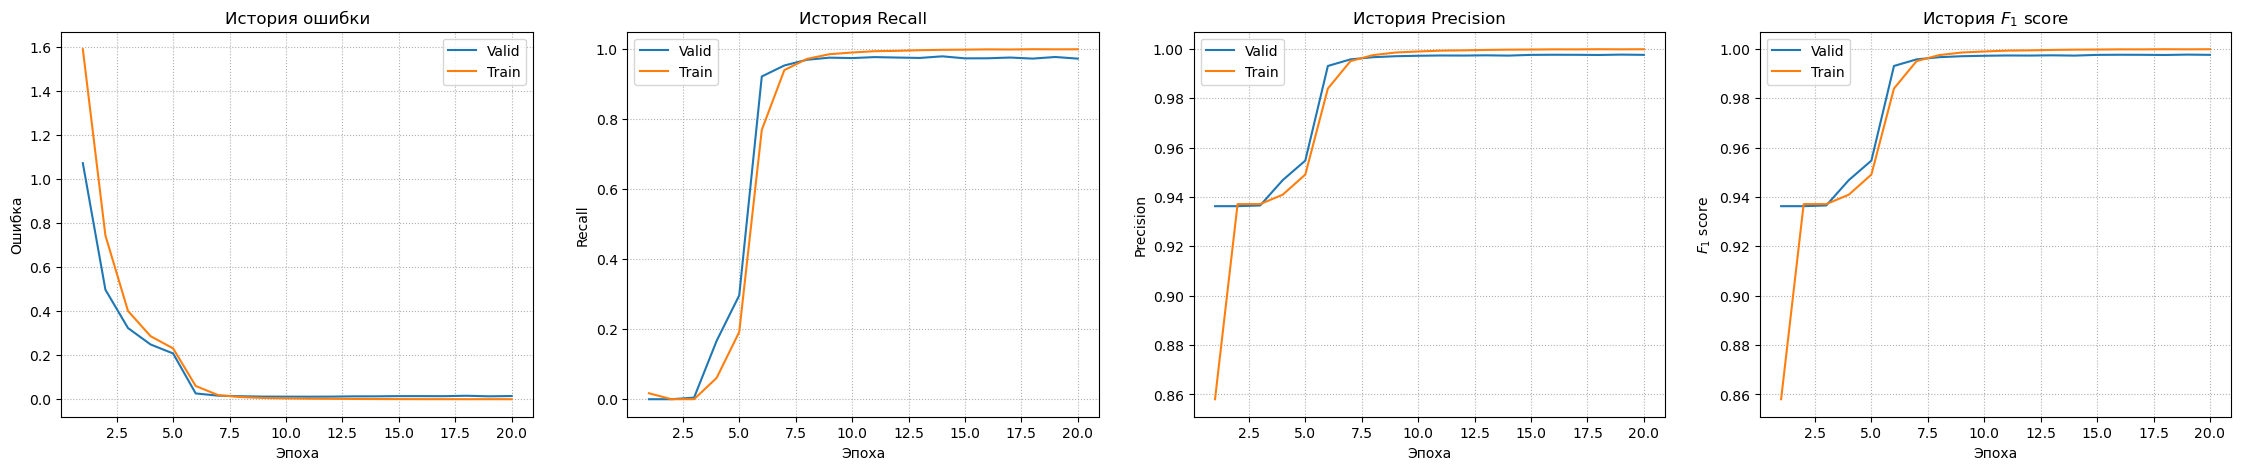

In [7]:
t_reader = TensorBoardReader(Path(bert_base_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(2)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [8]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=False,
                               pretrained_tokenizer="bert-base-cased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (1382 > 512). Running this sequence through the model will result in indexing errors


In [9]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(2)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [10]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9972580075263977
     test_precision         0.9972580075263977
       test_recall          0.9782907962799072
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9782907962799072,
  'test_precision': 0.9972580075263977,
  'test_f1': 0.9972580075263977}]

              precision    recall  f1-score   support

        NAME     0.2333    0.9721    0.3763     15310
  PROFESSION     0.9324    0.8622    0.8960       784
    LOCATION     0.9106    0.9382    0.9242      8142
         AGE     0.9465    0.9803    0.9631      1318
        DATE     0.9867    0.9961    0.9914     33003
          ID     0.9679    0.9646    0.9663      4694
     CONTACT     0.9622    0.9677    0.9649      1422
           O     0.9728    0.9985    0.9855    949928

   micro avg     0.9293    0.9973    0.9621   1014601
   macro avg     0.8641    0.9600    0.8835   1014601
weighted avg     0.9615    0.9973    0.9758   1014601



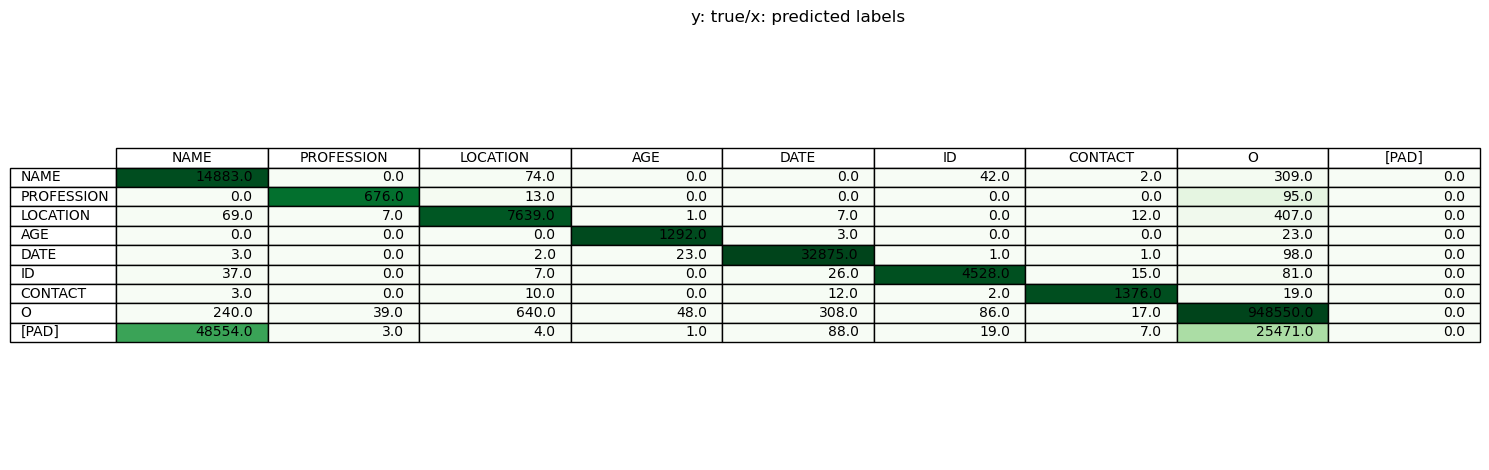

Wrongly predicted examples:
_____ Record 232-03:-12 _____
| Sentence:    | /    | 69   | HR | 62 | T | 98F | Hands | : | no | clubbing | H | + | N | : | no | elevated | JVP | , | erythema | and | injection | elft | eye | ? | conjunctivitis | , | no | nodes | CVS | : | normal | S1 | and | S2 | , | no | added | . | murmurs | / | rubs | heard | Chest | : | dull | right | abse | , | creps | bibasally | Abdo | : | SNT | , | distended | , | BS | present | Legs | : | no | odema | , | Calves | soft | LABS | : | Results | 02   |
| True labels: | O    | O    | O  | O  | O | O   | O     | O | O  | O        | O | O | O | O | O  | O        | O   | O | O        | O   | O         | O    | O   | O | O              | O | O  | O     | O   | O | O      | O  | O   | O  | O | O  | O     | O | O       | O | O    | O     | O     | O | O    | O     | O    | O | O     | O         | O    | O | O   | O | O         | O | O  | O       | O    | O | O  | O     | O | O      | O    | O    | O | O       | DATE |
| Pred

In [11]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-base-uncased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

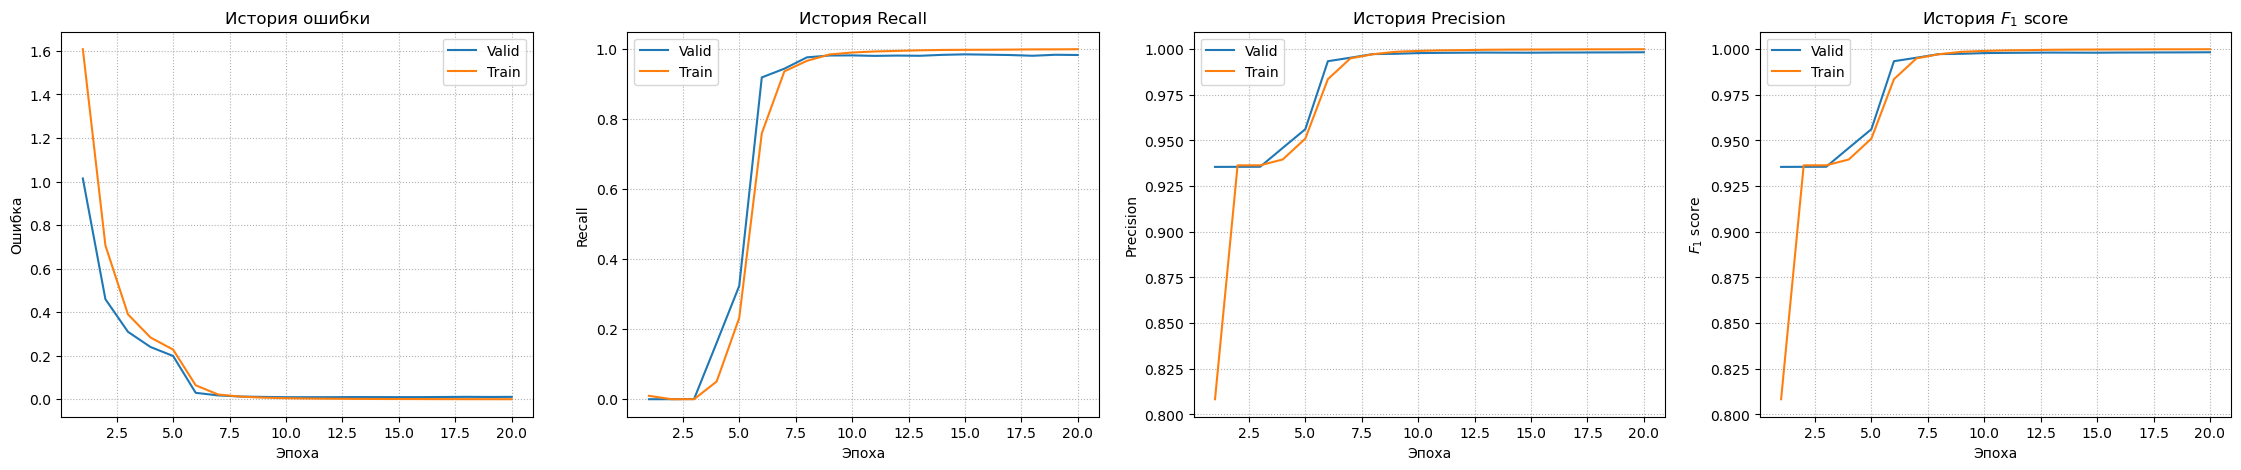

In [12]:
t_reader = TensorBoardReader(Path(bert_base_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(3)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [13]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer="bert-base-uncased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [14]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(3)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [15]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9980130791664124
     test_precision         0.9980130791664124
       test_recall           0.984548807144165
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.984548807144165,
  'test_precision': 0.9980130791664124,
  'test_f1': 0.9980130791664124}]

              precision    recall  f1-score   support

        NAME     0.5274    0.9770    0.6850     11741
  PROFESSION     0.8833    0.9116    0.8972       656
    LOCATION     0.9225    0.9543    0.9381      6211
         AGE     0.9478    0.9785    0.9629      1300
        DATE     0.9925    0.9959    0.9942     32754
          ID     0.7076    0.9825    0.8227      4510
     CONTACT     0.0346    0.9598    0.0668      1270
           O     0.9734    0.9989    0.9860    847998

   micro avg     0.9280    0.9980    0.9617    906440
   macro avg     0.7486    0.9698    0.7941    906440
weighted avg     0.9652    0.9980    0.9799    906440



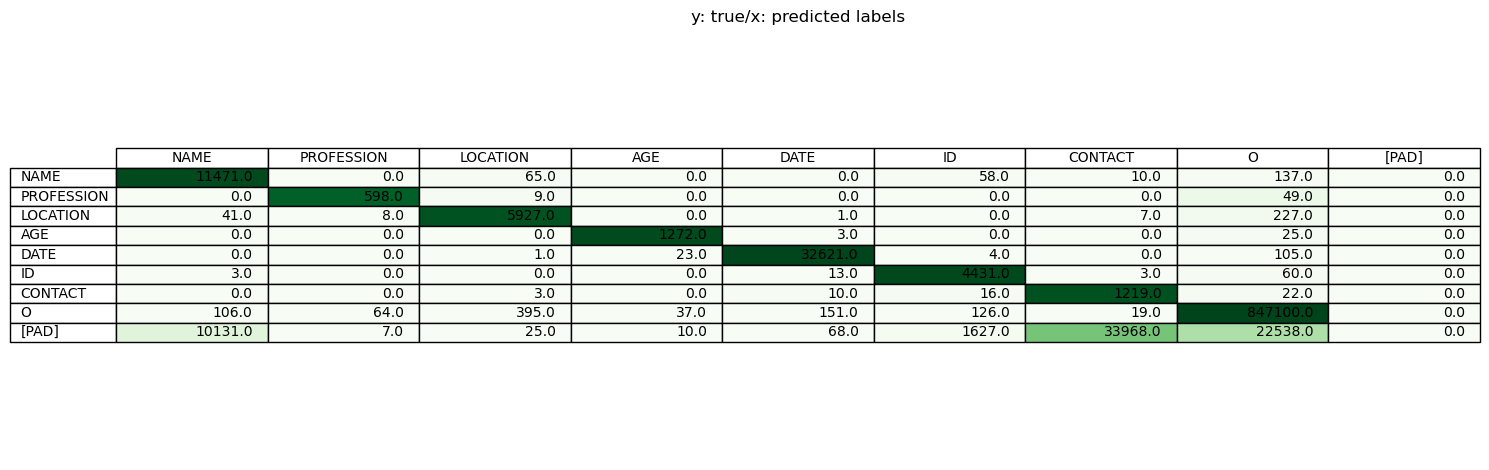

Wrongly predicted examples:
_____ Record 310-04:-8 _____
| Sentence:    | phos | 265 | tb | 0 | . | 6 | wbc | 9 | . | 71 | hct | 35 | . | 6 | plt | 366 | 67 | % | p | , | 17 | % | l | , | 6 | % | e | esr | 61 | cmv | 2    | /    | 9    | negative | microbiology | : | blood | 3    | /    | 02   | , | 3    | /    | 03   | ngtd | urine | 3    | /    | 02   | 1k | probable | enterococcus | stool | 3    | /    | 02   | culture | pending | 3    | /    | 03   | flu | / | paraflu | / | rsv | pending | radiology | : | cxr | 3    | /    | 02   | : | increased | moderate | effusions | since |
| True labels: | O    | O   | O  | O | O | O | O   | O | O | O  | O   | O  | O | O | O   | O   | O  | O | O | O | O  | O | O | O | O | O | O | O   | O  | O   | DATE | DATE | DATE | O        | O            | O | O     | DATE | DATE | DATE | O | DATE | DATE | DATE | O    | O     | DATE | DATE | DATE | O  | O        | O            | O     | DATE | DATE | DATE | O       | O       | DATE | DATE | DATE | O   | O |

In [16]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-large-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

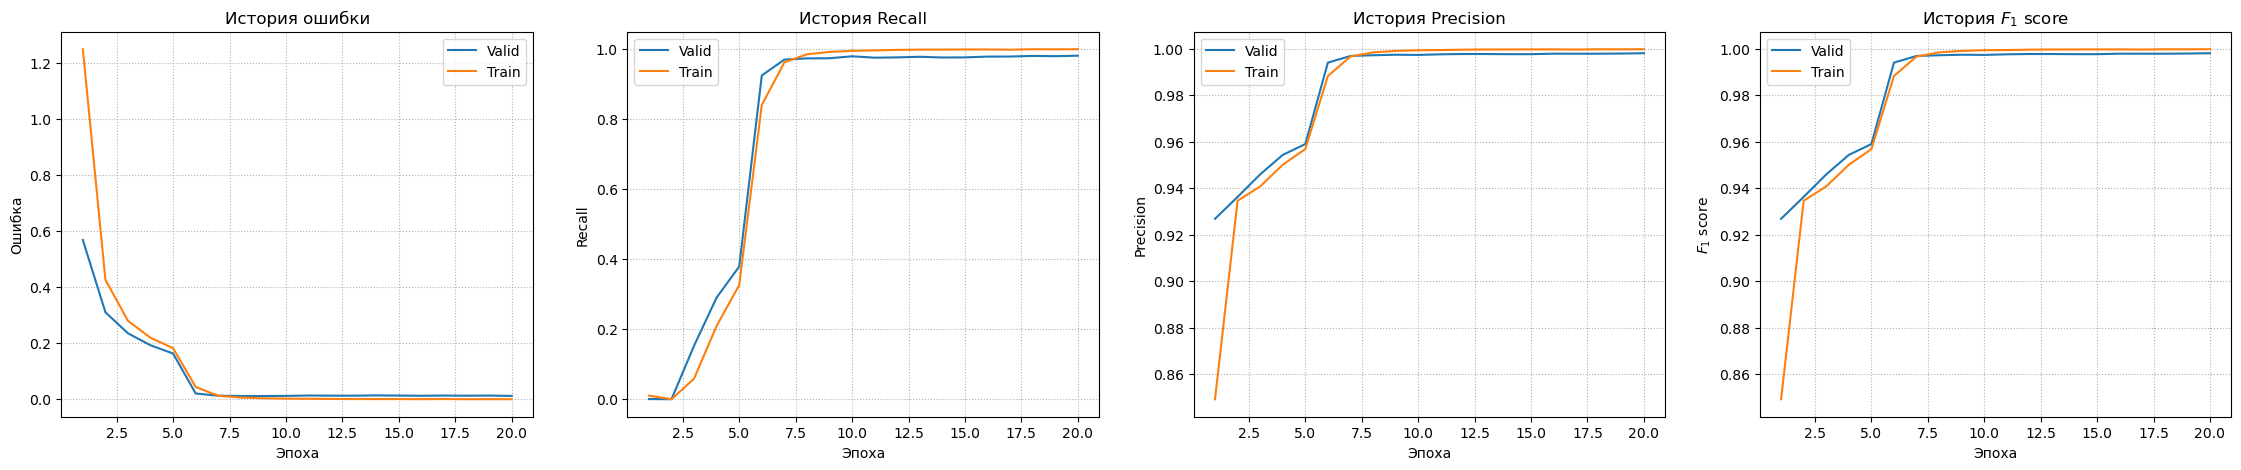

In [17]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(2)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [18]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=False,
                               pretrained_tokenizer="bert-large-cased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (1382 > 512). Running this sequence through the model will result in indexing errors


In [19]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(2)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [20]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9981667399406433
     test_precision         0.9981667399406433
       test_recall          0.9804709553718567
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9804709553718567,
  'test_precision': 0.9981667399406433,
  'test_f1': 0.9981667399406433}]

              precision    recall  f1-score   support

        NAME     0.9802    0.9767    0.9784     15310
  PROFESSION     0.9870    0.8712    0.9255       784
    LOCATION     0.3451    0.9381    0.5046      8142
         AGE     0.9716    0.9871    0.9793      1318
        DATE     0.9950    0.9954    0.9952     33003
          ID     0.9687    0.9768    0.9727      4694
     CONTACT     0.9873    0.9838    0.9856      1422
           O     0.9398    0.9994    0.9687    949928

   micro avg     0.9302    0.9982    0.9630   1014601
   macro avg     0.8968    0.9661    0.9137   1014601
weighted avg     0.9377    0.9982    0.9660   1014601



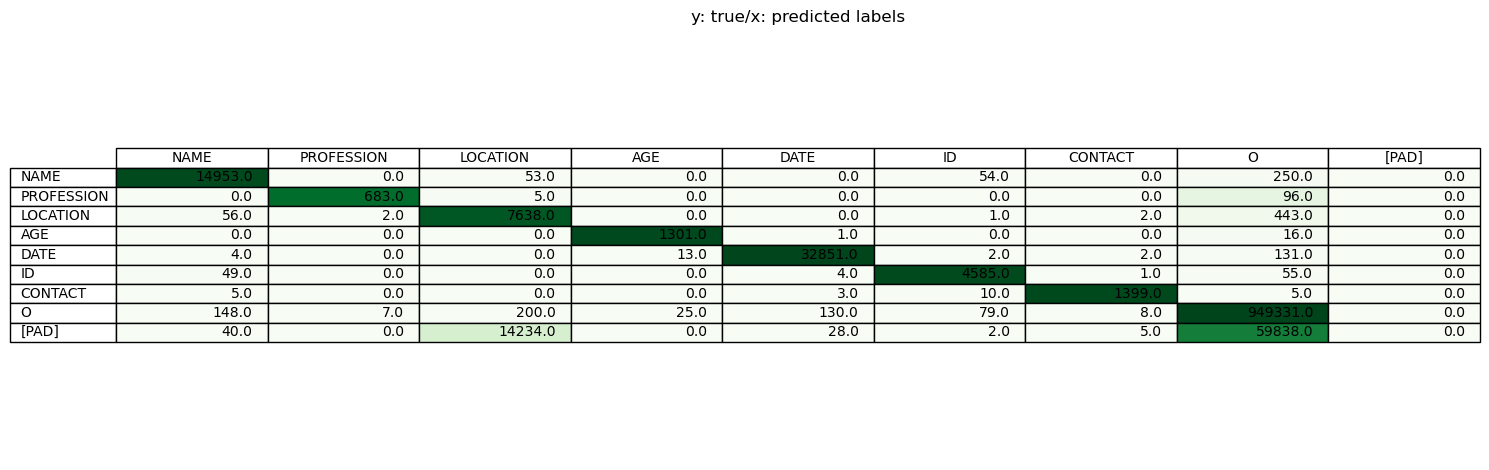

Wrongly predicted examples:
_____ Record 266-04:-19 _____
| Sentence:    | Record | date | : | 2069 | -    | 01   | -    | 13   | CHIEF | COMPLAINT | : | F | / | U | BH       | HISTORY | OF | PRESENT | ILLNESS | : | feeling | well | except | slight | cold | ; | getting | daily | exercise | and | still | not | smoking | ( | 2 | years | ) | f | / | u | type | 2 | DM | and | CAD | we | discussed | the | elevation | in | last | HbA1c | and | need | to | improve | control | ; | possible | need | for | insulin | future | not | yet | measuriong | home | glucose | : | given | instructions | a |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | O     | O         | O | O | O | O | O        | O       | O  | O       | O       | O | O       | O    | O      | O      | O    | O | O       | O     | O        | O   | O     | O   | O       | O | O | O     | O | O | O | O | O    | O | O  | O   | O   | O  | O         | O   | O         | O  | O    | O     | O   | O    | O  | O       | 

In [21]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-large-uncased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

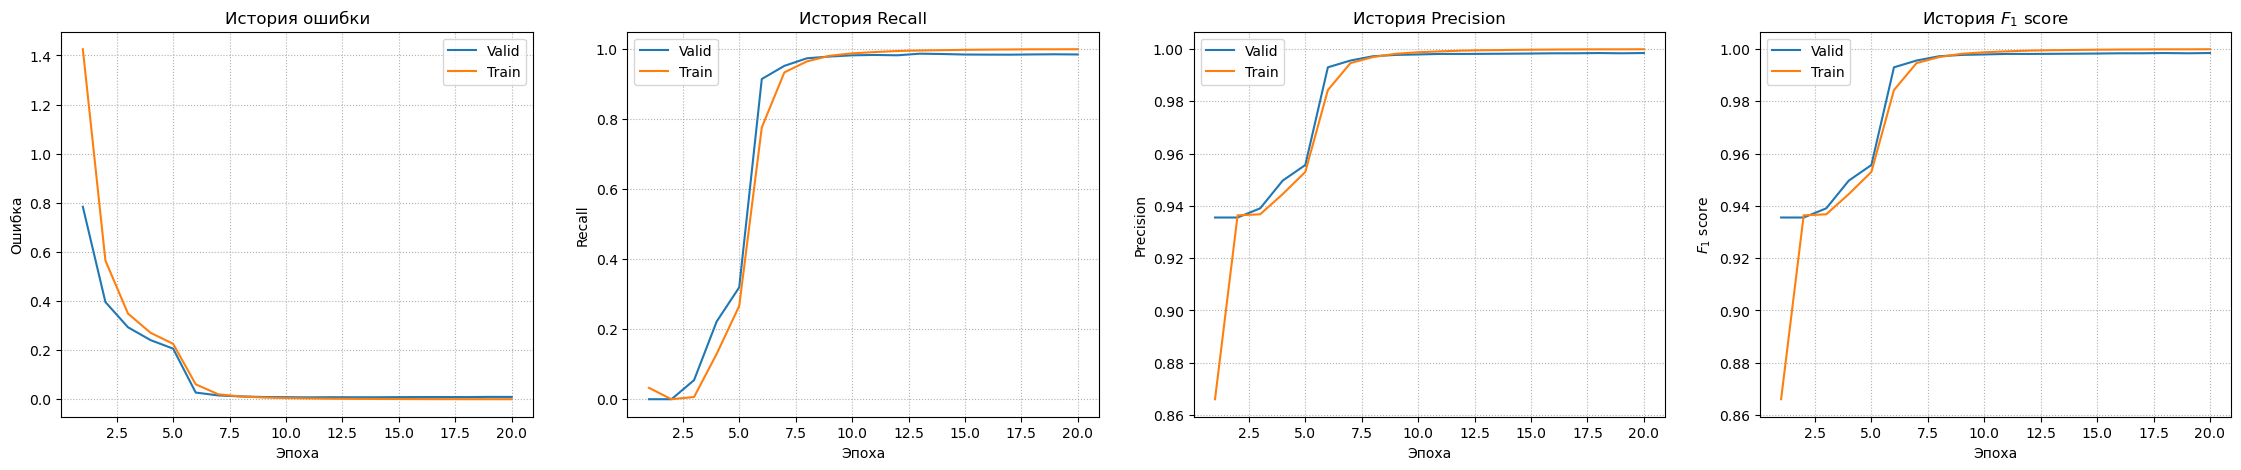

In [22]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(3)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [23]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer="bert-large-uncased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [24]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(3)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [25]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9981311559677124
     test_precision         0.9981311559677124
       test_recall           0.98619145154953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.98619145154953,
  'test_precision': 0.9981311559677124,
  'test_f1': 0.9981311559677124}]

              precision    recall  f1-score   support

        NAME     0.2222    0.9856    0.3626     11741
  PROFESSION     0.9207    0.9375    0.9290       656
    LOCATION     0.9377    0.9523    0.9450      6211
         AGE     0.9634    0.9731    0.9682      1300
        DATE     0.9888    0.9961    0.9924     32754
          ID     0.9372    0.9756    0.9560      4510
     CONTACT     0.7800    0.9772    0.8675      1270
           O     0.9680    0.9990    0.9832    847998

   micro avg     0.9281    0.9981    0.9619    906440
   macro avg     0.8397    0.9745    0.8755    906440
weighted avg     0.9584    0.9981    0.9749    906440



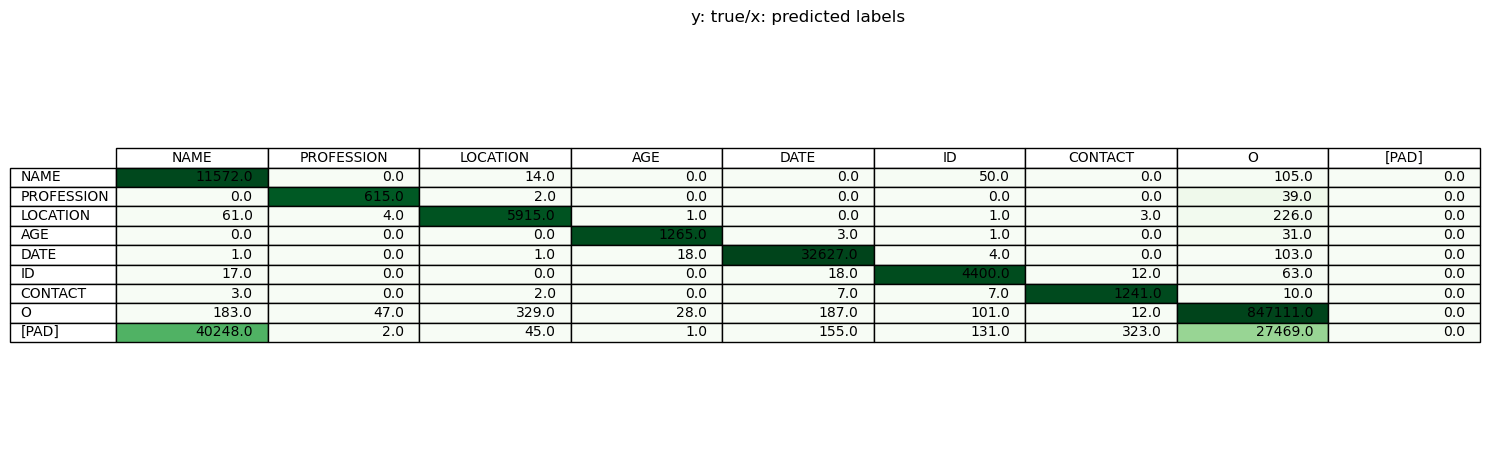

Wrongly predicted examples:
_____ Record 347-04:0 _____
| Sentence:    | for | questions | or | concerns | , | i | will | be | referring | betty | ' | s | care | to | one | of | the | more | junior | residents | . | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | elvin | cox  | md | , | mba | bmh      |
| True labels: | O   | O         | O  | O        | O | O | O    | O  | O         | NAME  | O | O | O    | O  | O   | O  | O   | O    | O      | O         | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | NAME  | NAME | O  | O | O   | LOCATION |
| Pred labels: | O   | O         | O  | O        | O | O | O    | O  | O         | NAME  | O | O | O    | O  | O   | O  | O   | O    | O      | O         | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | NAME  | NAME | O  | O | O   | LOCATION |
_____ Record 111-04:-2 _____
| Sentence:    | inpatie

In [26]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

Все классы кроме "PROFESSION" предсказываются с $Recall > 95\%$. Предположительно, это происходит из-за слабого представления класса в обучающей выборке. Для точности рассмотрим примеры ошибок его распознавания.

In [27]:
faults = stats.get_specific_failed_predictions('PROFESSION')

Wrongly predicted examples:
_____ Record 193-05:-34 _____
| Sentence:    | record | date | : | 2096 | -    | 03   | -    | 18   | foust | ,    | fay  | 50294530 | 03   | /    | 18   | /    | 2096 | bethany | downs | , | md       | linden   | internal | medicine | associates | 08       | kent     | lane     | , | a1       | -        | 49       | union    | city     | , | mo       | 43733    | 1 | . | hungary  | native | and | retired | health     | policy     | consultant | . | daughter | and | son | - | in | - | law | were | medical | school | classmates | of | dr | . | downs | . | 2 | . | alpha | thalassemia | trait | . | 12   | /    | 95   | hematocrit | 34 | . | 7 | , | mcv | 66 | . | 1 | , | rdw | 14 |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | NAME  | NAME | NAME | ID       | DATE | DATE | DATE | DATE | DATE | NAME    | NAME  | O | O        | LOCATION | O        | O        | O          | LOCATION | LOCATION | LOCATION | O | O        | O        | O     